In [29]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [30]:
import os
import sys
os.chdir('/content/gdrive/My Drive/grad-cam/.')

In [31]:
import tensorflow as tf
import pickle
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from PIL import Image

In [32]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    #This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    image = tf.image.resize(image, [224,224])
    return image, label

**The Final Resnet Model**

In [34]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout


def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    """
    Residual building block used by ResNet-50
    """
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]
        
 
    
    X = BatchNormalization()(X_start)      # default axis-1 is ok    
    X = Activation('relu')(X)
    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], use_bias=False, strides=strides_1, padding='same', name=name)(X)
    
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], use_bias=False, strides=[1,1], padding='same')(X)

    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)

    # X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    # X = BatchNormalization()(X)
    # X = Activation('relu')(X)
    
    # X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    # X = BatchNormalization()(X)
    
    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start
        
    X = Add()([X, X_res])
    # X = Activation('relu')(X)
    return X

def resnet50_v2(input_shape, nb_classes):
    assert len(input_shape) == 3
    
    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
    X = MaxPooling2D([3,3],padding='same', strides=[2,2])(X)
    # X = BatchNormalization(name='bn_conv1')(X)
    # X = Activation('relu')(X)


    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax')(X)
    # X = Dropout(0.3)(X)
    # X = Dense(14, activation="softmax")(X)

    # X = BatchNormalization(name='bn_conv1')(X)
    # X = Activation('relu')(X)
    # X = GlobalAveragePooling2D(name='avg_pool')(X)
    # X = Dropout(0.3)(X)
    # X = Dense(14, activation="softmax")(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [35]:
mymodel = resnet50_v2(input_shape=[224, 224, 3], nb_classes=14)

In [36]:
mymodel.load_weights('model2')

In [37]:
mymodel.summary()

Model: "model_4115"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv1[0][0]']                  
                                                                                         

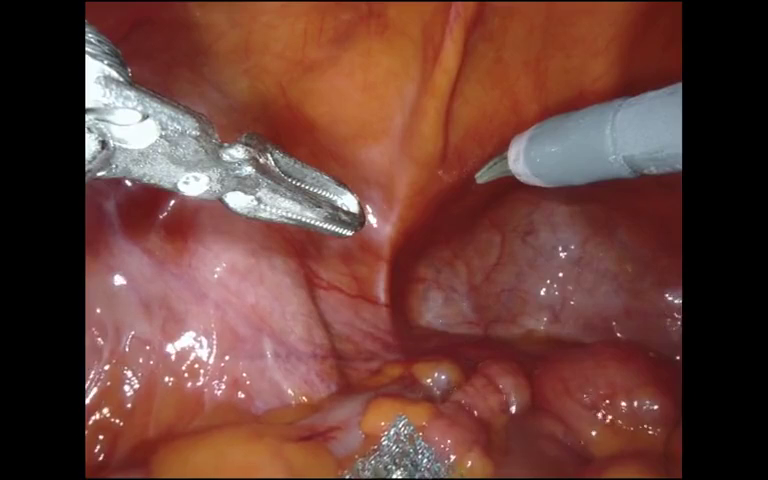

In [38]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [39]:
from matplotlib import image
from google.colab.patches import cv2_imshow

def save_and_display_gradcam(img_path, heatmap, alpha=0.4):


    img_category = img_path.split('/')[1]

    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    img_gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    img_gray = np.stack((img_gray,)*3, axis=-1)
    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img_gray
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    # dir = 'images/'+img_category
    # if not os.path.exists(dir):
    #   os.makedirs(dir)
    # superimposed_img.save(dir+'/cam.jpg')

    # Display Grad CAM

    # display(Image(dir+'/cam.jpg'))
    # img_cam = cv2.imread(dir+'/cam.jpg', cv2.IMREAD_ANYCOLOR)
    # cv2_imshow(img_cam)
    

    # img_gray = keras.preprocessing.image.array_to_img(img_gray)
    # img_gray.save(dir+'/gray.jpg')
    # display(Image(dir+'/gray.jpg'))
    # img_gray = cv2.imread(dir+'/gray.jpg', cv2.IMREAD_ANYCOLOR)
    # cv2_imshow(img_gray)

    # img = keras.preprocessing.image.array_to_img(img)
    # img.save(dir+'/original.jpg')
    # display(Image(dir+'/original.jpg'))
    # img = cv2.imread(dir+'/original.jpg', cv2.IMREAD_ANYCOLOR)
    # cv2_imshow(img)


In [ ]:

# preds_kaan = model_kaan.predict(img_array)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
# heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
# plt.matshow(heatmap)
# plt.show()

In [43]:



from tensorflow.keras.models import Model
import cv2
eps=1e-8




img_size = (224, 224)
layer_name = 'conv2d_71'
# The local path to our target image
img_folder = [
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0063',
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0088',
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0102',
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0111',
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0139',
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156',
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156',
            'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0170',
            # 'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0011/17-8.png',
            # 'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0053/29-13.png',
            # 'Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0047/1-13.png'
            ]
# display(Image(img_path))
img_path = []
for i in range(len(img_folder)):
  temp = [img_folder[i] + '/' + v for v in os.listdir(img_folder[i]) if v.endswith('png')]
  img_path += temp


img_size = (224, 224)
preprocess_input = keras.applications.resnet_v2.preprocess_input
decode_predictions = keras.applications.resnet_v2.decode_predictions

preds = [-1]*len(img_path)
sum_text = 0
sum_image = 0


In [47]:
from random import sample
img_path = sample(img_path,1000)

In [53]:


for i in range(len(img_path)):
  try:
    print(img_path[i])

    img_array = preprocess_input(get_img_array(img_path[i], size=img_size))
    preds[i] = mymodel.predict(img_array)
    gradModel = Model(
    inputs=[mymodel.inputs],
    outputs=[mymodel.get_layer(layer_name).output,
    mymodel.output])
    with tf.GradientTape() as tape:
      # cast the image tensor to a float-32 data type, pass the
      # forward propagate the image through the gradient model, and grab the loss
      # associated with the specific class index
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    sum_text += sum(sum(heatmap[200:][:]))
    sum_image += sum(sum(heatmap[:200][:]))
    # plt.matshow(heatmap)
    # plt.show()
  except:
    continue


  # save_and_display_gradcam(img_path[i], heatmap)
average_text = sum_text / heatmap[200:][:].size / len(img_path)
average_image = sum_image / heatmap[:200][:].size / len(img_path)
print("average result in text position is: "+str(average_text))
print("average result in image position is: "+str(average_image))

Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0063/3227-6.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/2554-6.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/2793-8.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/142-7.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0139/2509-12.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0170/2111-13.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/356-11.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/1042-11.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0111/620-11.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0063/1718-13.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0111/1727-2.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/883-11.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/3069-13.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0156/2055-8.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0170/187-11.png
Surgery_Images_Hernia/RALIHR_surgeon01_fps01_0111/1511-3.png
Surgery_Images_Herni

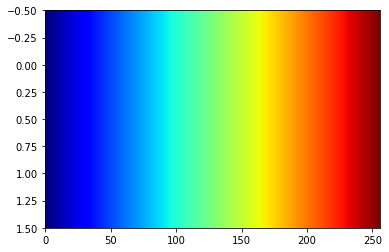

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow( gradient, aspect='auto', cmap='jet')


In [ ]:
(jet = cm.get_cmap("jet")

In [ ]:
jet_heatmap = jet_colors[heatmap]

In [ ]:
jet(np.arange(256))[254,:3]

array([0.51782531, 0.        , 0.        ])

In [ ]:
jet_colors = jet(np.arange(256))[:, :3]

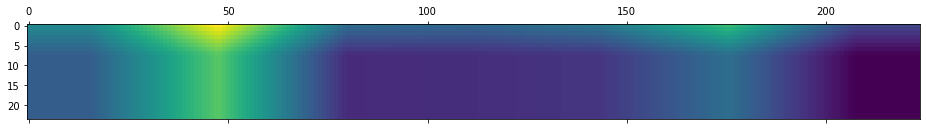

In [ ]:
plt.matshow(heatmap[200:][:])
plt.show()

In [ ]:
sum(sum(heatmap[200:][:]))/heatmap[200:][:].size

0.2159979676472999

In [ ]:
sum(sum(heatmap[:200][:]))/heatmap[:200][:].size

0.44362979446138656

In [ ]:
jet_heatmap = jet_colors[heatmap]
jet_heatmap[:,1]

IndexError: ignored

In [ ]:
display(Image(cam_path))

In [ ]:
save_and_display_gradcam(img_path, heatmap)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


cmaps = [('Perceptually Uniform Sequential', [
            'viridis', 'plasma', 'inferno', 'magma', 'cividis']),
         ('Sequential', [
            'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
            'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
            'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']),
         ('Sequential (2)', [
            'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone', 'pink',
            'spring', 'summer', 'autumn', 'winter', 'cool', 'Wistia',
            'hot', 'afmhot', 'gist_heat', 'copper']),
         ('Diverging', [
            'PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']),
         ('Cyclic', ['twilight', 'twilight_shifted', 'hsv']),
         ('Qualitative', [
            'Pastel1', 'Pastel2', 'Paired', 'Accent',
            'Dark2', 'Set1', 'Set2', 'Set3',
            'tab10', 'tab20', 'tab20b', 'tab20c']),
         ('Miscellaneous', [
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral',
            'gist_ncar'])]


gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows-1)*0.1)*0.22
    fig, axs = plt.subplots(nrows=nrows, figsize=(6.4, figh))
    fig.subplots_adjust(top=1-.35/figh, bottom=.15/figh, left=0.2, right=0.99)

    axs[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for ax, cmap_name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=cmap_name)
        ax.text(-.01, .5, cmap_name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()


for cmap_category, cmap_list in cmaps:
    # print(cmap_category,cmap_list)
    plot_color_gradients(cmap_category, cmap_list)


plt.show()

In [ ]:
a = tf.constant([[1., 3.], [2., 2.]])

In [ ]:
tf.reduce_mean(a,(0,1))

<tf.Tensor: shape=(), dtype=float32, numpy=2.0>

In [ ]:
pooled_grads[..., tf.newaxis]

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.07142857]], dtype=float32)>